# 3-1,低阶API示范

下面的范例使用Pytorch的低阶API实现线性回归模型和DNN二分类模型。

低阶API主要包括张量操作，计算图和自动微分。

In [3]:
import os
import datetime

#打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

#mac系统上pytorch和matplotlib在jupyter中同时跑需要更改环境变量
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" 


### 一，线性回归模型

**1，准备数据**

In [14]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
import torch
from torch import nn


#样本数量
n = 400

# 生成测试用数据集
X = 10*torch.rand([n,2])-5.0  #torch.rand是均匀分布 
w0 = torch.tensor([[2.0],[-3.0]])
b0 = torch.tensor([[10.0]])
Y = X@w0 + b0 + torch.normal( 0.0,2.0,size = [n,1])  # @表示矩阵乘法,增加正态扰动


torch.Size([2, 1])

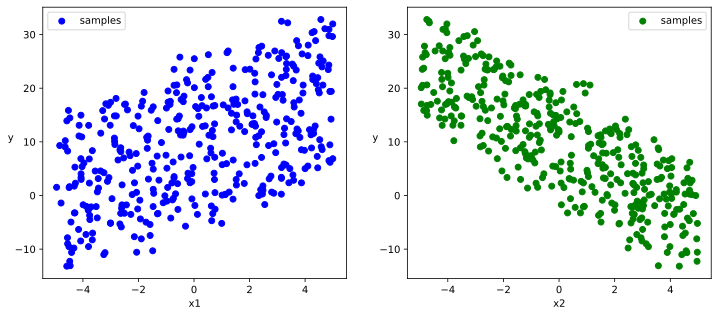

In [15]:
# 数据可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0].numpy(),Y[:,0].numpy(), c = "b",label = "samples")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1].numpy(),Y[:,0].numpy(), c = "g",label = "samples")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)
plt.show()


![](./data/3-1-回归数据可视化.png)

In [17]:
# 构建数据管道迭代器
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)  #样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        indexs = torch.LongTensor(indices[i: min(i + batch_size, num_examples)])
        yield  features.index_select(0, indexs), labels.index_select(0, indexs)
        
# 测试数据管道效果   
batch_size = 8
(features,labels) = next(data_iter(X,Y,batch_size))
print(features)
print(labels)


tensor([[-2.6180,  3.8003],
        [-2.6369, -1.3907],
        [-0.9753,  1.5758],
        [ 3.7596, -4.3092],
        [ 1.0232,  1.6963],
        [-4.5022,  3.2131],
        [ 3.5934, -0.1152],
        [-4.3116, -0.2631]])
tensor([[-5.8680],
        [ 8.8974],
        [ 5.0862],
        [27.9025],
        [ 7.8774],
        [-9.5421],
        [17.2910],
        [ 1.7408]])


```
tensor([[-4.3880,  1.3655],
        [-0.1082,  3.9533],
        [-2.6286,  2.7058],
        [ 1.0604, -1.8646],
        [-1.5805,  1.5406],
        [-2.6217, -3.2342],
        [ 2.3748, -0.6449],
        [-1.2478, -2.0509]])
tensor([[-0.2069],
        [-3.2494],
        [-6.9620],
        [17.0528],
        [ 1.1076],
        [17.2117],
        [16.1081],
        [14.7092]])
```

**2，定义模型**

In [18]:
# 定义模型
class LinearRegression: 
    
    def __init__(self):
        self.w = torch.randn_like(w0,requires_grad=True)
        self.b = torch.zeros_like(b0,requires_grad=True)
        
    #正向传播
    def forward(self,x): 
        return x@self.w + self.b

    # 损失函数
    def loss_func(self,y_pred,y_true):  
        return torch.mean((y_pred - y_true)**2/2)

model = LinearRegression()


**3，训练模型**

In [22]:
def train_step(model, features, labels):
    
    predictions = model.forward(features)
    loss = model.loss_func(predictions,labels)
    
    # 反向传播求梯度
    loss.backward()
    
    # 使用torch.no_grad()避免梯度记录，也可以通过操作 model.w.data 实现避免梯度记录 
    with torch.no_grad():
        # 梯度下降法更新参数
        model.w -= 0.001*model.w.grad
        model.b -= 0.001*model.b.grad

        # 梯度清零
        model.w.grad.zero_()
        model.b.grad.zero_()
    return loss
 

In [23]:
# 测试train_step效果
batch_size = 10
(features,labels) = next(data_iter(X,Y,batch_size))
train_step(model,features,labels)


tensor(343.0714, grad_fn=<MeanBackward0>)

```
tensor(92.8199, grad_fn=<MeanBackward0>)
```

In [24]:
def train_model(model,epochs):
    for epoch in range(1,epochs+1):
        for features, labels in data_iter(X,Y,10):
            loss = train_step(model,features,labels)

        if epoch%200==0:
            printbar()
            print("epoch =",epoch,"loss = ",loss.item())
            print("model.w =",model.w.data)
            print("model.b =",model.b.data)

train_model(model,epochs = 1000)



================================================================================2021-06-30 21:50:17
epoch = 200 loss =  1.130333662033081
model.w = tensor([[ 1.9901],
        [-2.9397]])
model.b = tensor([[9.5933]])

================================================================================2021-06-30 21:50:18
epoch = 400 loss =  3.8773550987243652
model.w = tensor([[ 1.9881],
        [-2.9385]])
model.b = tensor([[9.5966]])

================================================================================2021-06-30 21:50:20
epoch = 600 loss =  1.6518709659576416
model.w = tensor([[ 1.9877],
        [-2.9383]])
model.b = tensor([[9.5969]])

================================================================================2021-06-30 21:50:21
epoch = 800 loss =  2.8458311557769775
model.w = tensor([[ 1.9898],
        [-2.9398]])
model.b = tensor([[9.5968]])

================================================================================2021-06-30 21:50:22
epoch = 1000 loss =  2.15512

```
================================================================================2020-07-05 08:27:57
epoch = 200 loss =  2.6340413093566895
model.w = tensor([[ 2.0283],
        [-2.9632]])
model.b = tensor([[10.0748]])

================================================================================2020-07-05 08:28:00
epoch = 400 loss =  2.24908709526062
model.w = tensor([[ 2.0300],
        [-2.9643]])
model.b = tensor([[10.0781]])

================================================================================2020-07-05 08:28:04
epoch = 600 loss =  1.510349154472351
model.w = tensor([[ 2.0290],
        [-2.9630]])
model.b = tensor([[10.0781]])

================================================================================2020-07-05 08:28:07
epoch = 800 loss =  1.038671851158142
model.w = tensor([[ 2.0314],
        [-2.9649]])
model.b = tensor([[10.0785]])

================================================================================2020-07-05 08:28:10
epoch = 1000 loss =  1.9742190837860107
model.w = tensor([[ 2.0313],
        [-2.9648]])
model.b = tensor([[10.0781]])
```

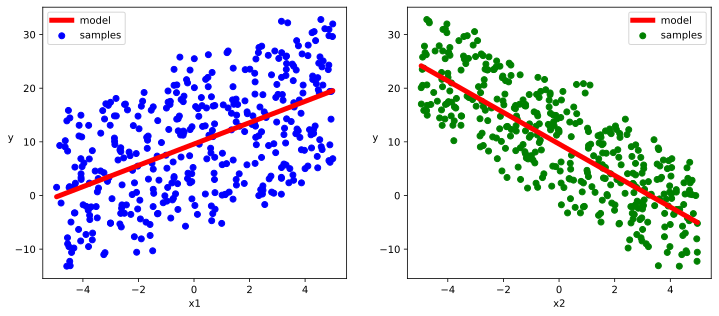

In [25]:
# 结果可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0].numpy(),Y[:,0].numpy(), c = "b",label = "samples")
ax1.plot(X[:,0].numpy(),(model.w[0].data*X[:,0]+model.b[0].data).numpy(),"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)


ax2 = plt.subplot(122)
ax2.scatter(X[:,1].numpy(),Y[:,0].numpy(), c = "g",label = "samples")
ax2.plot(X[:,1].numpy(),(model.w[1].data*X[:,1]+model.b[0].data).numpy(),"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)

plt.show()

![](./data/3-1-回归结果可视化.png)

### 二，DNN二分类模型

**1，准备数据**

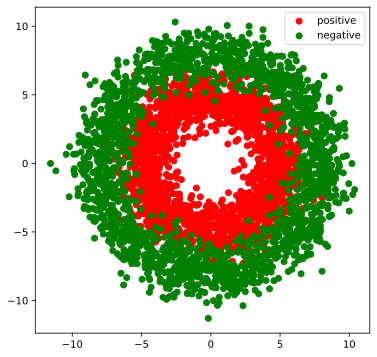

In [28]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import torch
from torch import nn
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#正负样本数量
n_positive,n_negative = 2000,2000

#生成正样本, 小圆环分布
r_p = 5.0 + torch.normal(0.0,1.0,size = [n_positive,1]) 
theta_p = 2*np.pi*torch.rand([n_positive,1])
Xp = torch.cat([r_p*torch.cos(theta_p),r_p*torch.sin(theta_p)],axis = 1)
Yp = torch.ones_like(r_p)

#生成负样本, 大圆环分布
r_n = 8.0 + torch.normal(0.0,1.0,size = [n_negative,1]) 
theta_n = 2*np.pi*torch.rand([n_negative,1])
Xn = torch.cat([r_n*torch.cos(theta_n),r_n*torch.sin(theta_n)],axis = 1)
Yn = torch.zeros_like(r_n)

#汇总样本
X = torch.cat([Xp,Xn],axis = 0)
Y = torch.cat([Yp,Yn],axis = 0)


#可视化
plt.figure(figsize = (6,6))
plt.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
plt.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
plt.legend(["positive","negative"]);


In [31]:
Yn

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])

![](./data/3-1-分类数据可视化.png)

In [26]:
# 构建数据管道迭代器
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)  #样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        indexs = torch.LongTensor(indices[i: min(i + batch_size, num_examples)])
        yield  features.index_select(0, indexs), labels.index_select(0, indexs)
        
# 测试数据管道效果   
batch_size = 8
(features,labels) = next(data_iter(X,Y,batch_size))
print(features)
print(labels)


tensor([[ 4.9425, -0.6595],
        [-1.9302,  2.6623],
        [ 3.8131,  2.1911],
        [-3.6625,  2.5390],
        [-0.3870, -3.9744],
        [ 4.3778, -2.9288],
        [-0.9080, -1.7180],
        [ 0.4487, -2.4295]])
tensor([[19.4046],
        [-4.3750],
        [10.8245],
        [-8.2733],
        [17.4887],
        [28.8663],
        [12.3082],
        [16.3134]])


```
tensor([[ 6.9914, -1.0820],
        [ 4.8156,  4.0532],
        [-1.0697, -7.4644],
        [ 2.6291,  3.8851],
        [-1.6780, -4.3390],
        [-6.1495,  1.2269],
        [-4.3422,  3.9552],
        [-6.2265,  2.6159]])
tensor([[0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])
```

**2，定义模型**

此处范例我们利用nn.Module来组织模型变量。

In [32]:
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.w1 = nn.Parameter(torch.randn(2,4))
        self.b1 = nn.Parameter(torch.zeros(1,4))
        self.w2 = nn.Parameter(torch.randn(4,8))
        self.b2 = nn.Parameter(torch.zeros(1,8))
        self.w3 = nn.Parameter(torch.randn(8,1))
        self.b3 = nn.Parameter(torch.zeros(1,1))

    # 正向传播
    def forward(self,x):
        x = torch.relu(x@self.w1 + self.b1)
        x = torch.relu(x@self.w2 + self.b2)
        y = torch.sigmoid(x@self.w3 + self.b3)
        return y
    
    # 损失函数(二元交叉熵)
    def loss_func(self,y_pred,y_true):  
        #将预测值限制在1e-7以上, 1- (1e-7)以下，避免log(0)错误
        eps = 1e-7
        y_pred = torch.clamp(y_pred,eps,1.0-eps)
        bce = - y_true*torch.log(y_pred) - (1-y_true)*torch.log(1-y_pred)
        return torch.mean(bce)
    
    # 评估指标(准确率)
    def metric_func(self,y_pred,y_true):
        y_pred = torch.where(y_pred>0.5,torch.ones_like(y_pred,dtype = torch.float32),
                          torch.zeros_like(y_pred,dtype = torch.float32))
        acc = torch.mean(1-torch.abs(y_true-y_pred))
        return acc
    
model = DNNModel()


In [33]:
# 测试模型结构
batch_size = 10
(features,labels) = next(data_iter(X,Y,batch_size))

predictions = model(features)

loss = model.loss_func(labels,predictions)
metric = model.metric_func(labels,predictions)

print("init loss:", loss.item())
print("init metric:", metric.item())


init loss: 10.758578300476074
init metric: 0.33062344789505005


```
init loss: 7.979694366455078
init metric: 0.50347900390625
```

In [ ]:
len(list(model.parameters()))

```
6
```

**3，训练模型**

In [34]:
def train_step(model, features, labels):   
    
    # 正向传播求损失
    predictions = model.forward(features)
    loss = model.loss_func(predictions,labels)
    metric = model.metric_func(predictions,labels)
        
    # 反向传播求梯度
    loss.backward()
    
    # 梯度下降法更新参数
    for param in model.parameters():
        #注意是对param.data进行重新赋值,避免此处操作引起梯度记录
        param.data = (param.data - 0.01*param.grad.data) 
        
    # 梯度清零
    model.zero_grad()
        
    return loss.item(),metric.item()
 

def train_model(model,epochs):
    for epoch in range(1,epochs+1):
        loss_list,metric_list = [],[]
        for features, labels in data_iter(X,Y,20):
            lossi,metrici = train_step(model,features,labels)
            loss_list.append(lossi)
            metric_list.append(metrici)
        loss = np.mean(loss_list)
        metric = np.mean(metric_list)

        if epoch%100==0:
            printbar()
            print("epoch =",epoch,"loss = ",loss,"metric = ",metric)
        
train_model(model,epochs = 1000)



================================================================================2021-06-30 22:12:08
epoch = 100 loss =  0.26654083617031576 metric =  0.8852499970793724

================================================================================2021-06-30 22:12:18
epoch = 200 loss =  0.2064010495878756 metric =  0.920749993622303

================================================================================2021-06-30 22:12:29
epoch = 300 loss =  0.20246644102036954 metric =  0.9219999927282333

================================================================================2021-06-30 22:12:39
epoch = 400 loss =  0.19922088709659874 metric =  0.9239999932050705

================================================================================2021-06-30 22:12:50
epoch = 500 loss =  0.19371811707504094 metric =  0.9172499939799309

================================================================================2021-06-30 22:13:00
epoch = 600 loss =  0.19830166869796811 metric =  0

```
================================================================================2020-07-05 08:32:16
epoch = 100 loss =  0.24841043589636683 metric =  0.8944999960064888

================================================================================2020-07-05 08:32:34
epoch = 200 loss =  0.20398724960163236 metric =  0.920999992787838

================================================================================2020-07-05 08:32:54
epoch = 300 loss =  0.19509393003769218 metric =  0.9239999914169311

================================================================================2020-07-05 08:33:14
epoch = 400 loss =  0.19067603485658766 metric =  0.9272499939799309

================================================================================2020-07-05 08:33:33
epoch = 500 loss =  0.1898010154720396 metric =  0.9237499925494194

================================================================================2020-07-05 08:33:54
epoch = 600 loss =  0.19151576517149807 metric =  0.9254999926686287

================================================================================2020-07-05 08:34:18
epoch = 700 loss =  0.18914461021777243 metric =  0.9274999949336052

================================================================================2020-07-05 08:34:39
epoch = 800 loss =  0.18801998342387377 metric =  0.9264999932050705

================================================================================2020-07-05 08:35:00
epoch = 900 loss =  0.1852504052128643 metric =  0.9249999937415123

================================================================================2020-07-05 08:35:21
epoch = 1000 loss =  0.18695520935580134 metric =  0.9272499927878379
```

In [48]:
print((model.forward(X)>=0.5).shape)
print(torch.squeeze(model.forward(X)>=0.5).shape)

torch.Size([4000, 1])
torch.Size([4000])


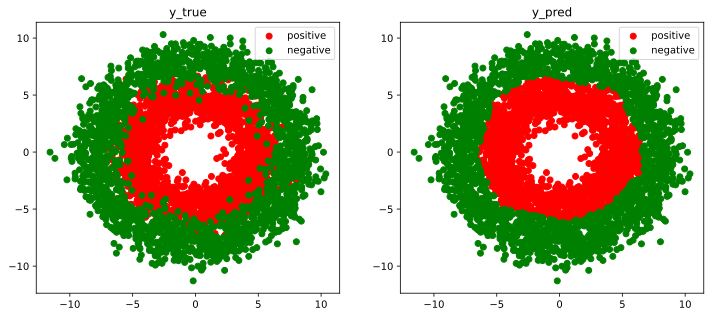

In [36]:
# 结果可视化
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(Xp[:,0],Xp[:,1], c="r")
ax1.scatter(Xn[:,0],Xn[:,1],c = "g")
ax1.legend(["positive","negative"]);
ax1.set_title("y_true");

Xp_pred = X[torch.squeeze(model.forward(X)>=0.5)]
Xn_pred = X[torch.squeeze(model.forward(X)<0.5)]

ax2.scatter(Xp_pred[:,0],Xp_pred[:,1],c = "r")
ax2.scatter(Xn_pred[:,0],Xn_pred[:,1],c = "g")
ax2.legend(["positive","negative"]);
ax2.set_title("y_pred");


![](./data/3-1-分类结果可视化.png)

**如果本书对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果对本书内容理解上有需要进一步和作者交流的地方，欢迎在公众号"算法美食屋"下留言。作者时间和精力有限，会酌情予以回复。

也可以在公众号后台回复关键字：**加群**，加入读者交流群和大家讨论。

![算法美食屋logo.png](./data/算法美食屋二维码.jpg)